In [95]:
##### Tool CSV -> pickle

import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import copy
import random
import time
from collections import defaultdict
from tqdm.notebook import tqdm
import h5py



#Hello,
#Please ask yourself the four questinons below.
                          ####
                          ####
                          ####
                          ####
                ########################
                   ##################
                      ############
                         #######
                           ###
                            #
#Question Zero:

#Do I want to create a fresh trainings set (labeled data)? Set model_use=0

#                               or


#Do I want to use the trained PID network on unkown data (unlabeled)? Set model_use=1 

model_use=1 #(yes=1, no=0)


#Question One:
#How many files do you want to transfrom into a fromat for the Neural Networks?
#If you deal with 1000+ Events, it is wise to set set "intermediate_safes" to 1. 

intermediate_safes = 0 #This stores temporary files on the disk to not overload the RAM 
Path_to_Temp = 'Temp/'
#Path to store your pickle-Data for your Network for later use
Path_to_Pickle = 'pickle/'
Pickle_nameX ="X" #Name of the training data-pickle file
Pickle_nameY ="Y" #Name of the true values-pickle file

#Question Two:
### ---> Which Resolution have you set for a LAPPD tile? 
# LAPPD behaves like a PMT -> LAPPD_res=1 ; LAPPD has a 5x5 resolution -> LAPPD_res=5
LAPPD_res = 5

#Question Three:
### --->How many LAPPDs are you using?
LAPPD_num = 24



##################################  Paths  ###############################################



##Path to Folder containing only the file(s)
# ->How many files do you want to check? 
#
#DATADIR_Label1 ="C:/Users/Deep Thought/Documents/Python/CNN_Masterarbeit/BeamlikePI/csv/beamlike_electrons_updatedMRD_DigitThr0/"
#DATADIR_Label2 ="C:/Users/Deep Thought/Documents/Python/CNN_Masterarbeit/BeamlikePI/csv/beamlike_muons_updatedMRD_DigitThr0/"
numberFiles_Label1 =3 #int(len(os.listdir(DATADIR_Label1)))
numberFiles_Label2 =3 #int(len(os.listdir(DATADIR_Label2)))



## Path to File(s)  
# Make sure that your file(s) follow a specif delceration:
# name_number_charge.csv  --> e.g. beamlike_electrons_0_charge.csv
# name_number_time.csv
# name_number_MRD.csv
# The Path end right before the number e.g. "C:/Users/.../beamlike_electrons_"
DATAFile_Label1 ="C:/Users/Deep Thought/Documents/Python/CNN_Masterarbeit/Tools/csv/Electron/beamlike_PI_electron_lappd5x5_"
DATAFile_Label2 ="C:/Users/Deep Thought/Documents/Python/CNN_Masterarbeit/Tools/csv/Muon/beamlike_PI_muon_lappd5x5_" 

##########################################################################################

#### From here on should the program work on its own




### Charge Values
# PMT
Charge_values =np.zeros((0,160))
for i in tqdm(range(numberFiles_Label1)):
    try:
        training_data_list = np.loadtxt(DATAFile_Label1+str(i)+"_charge.csv", delimiter = ",")
        #print(training_data_list.shape,all_values.shape)
        Charge_values = np.concatenate([Charge_values,training_data_list],axis=0)
    except OSError:
        print("File {} not found".format(i))
        continue
if model_use == 0:
    for i in tqdm(range(numberFiles_Label2)):
        try:
            training_data_list = np.loadtxt(DATAFile_Label2+str(i)+"_charge.csv", delimiter = ",")
            #print(training_data_list.shape,all_values.shape)
            Charge_values = np.concatenate([Charge_values,training_data_list],axis=0)
        except OSError:
            print("File {} not found".format(i))
            continue
batchsize=len(Charge_values)
if intermediate_safes == 1:        
    np.save(Path_to_Temp+'ChargePMT', Charge_values)
    del Charge_values
print("PMT Charge Data ready")        
        
#LAPPD
Charge_values_Lappd = np.zeros((0,LAPPD_num*LAPPD_res**2))

for i in tqdm(range(numberFiles_Label1)):
    try:
        training_data_list = np.loadtxt(DATAFile_Label1+str(i)+"_lappd_charge.csv", delimiter = ",")
        Charge_values_Lappd = np.concatenate([Charge_values_Lappd,training_data_list],axis=0)      
    except OSError:
        print("File {} not found".format(i))   
if model_use == 0:        
    for i in tqdm(range(numberFiles_Label2)):
        try:
            training_data_list = np.loadtxt(DATAFile_Label2+str(i)+"_lappd_charge.csv", delimiter = ",")
            Charge_values_Lappd = np.concatenate([Charge_values_Lappd,training_data_list],axis=0)
        except OSError:
            print("File {} not found".format(i)) 
if intermediate_safes == 1:        
    np.save(Path_to_Temp+'ChargeLAPPD', Charge_values_Lappd)
    del Charge_values_Lappd
print("LAPPD Charge Data ready")     
    
### Time Values

# PMT
time_values =np.zeros((0,160))
for i in tqdm(range(numberFiles_Label1)):
    try:
        #Inefficient, I know...
        # What is happaning here?
        #Charge data gets checked for empty events (everything is then zero for the time data).
        # Time values get flipped (early arrivel -> high value, late -> small value)
        training_data_listT = np.loadtxt(DATAFile_Label1+str(i)+"_time.csv", delimiter = ",")
        training_data_listC = np.loadtxt(DATAFile_Label1+str(i)+"_charge.csv", delimiter = ",")
        newlist1=[]
        for element in range(len(training_data_listT)):
            if sum(training_data_listC[element]) == 0:
                newlist1.append(np.zeros((160*1)))
                
            else:
                newlist=[]
                for k in training_data_listT[element]:
                    if k==0:
                        newlist.append(0)
                    else:
                        newlist.append(1-k)
                    
                newlist1.append(newlist)
        newlist1= np.array(newlist1)
        #print(newlist1.shape,training_data_listT.shape)
        time_values = np.concatenate([time_values,newlist1],axis=0)
        
    except OSError:
        print("File {} not found".format(i))
if model_use == 0:
    for i in tqdm(range(numberFiles_Label2)):
        try:
            #Inefficient, I know...
            # What is happaning here?
            #Charge data gets checked for empty events (everything is then zero for the time data).
            # Time values get flipped (early arrivel -> high value, late -> small value)
            training_data_listT = np.loadtxt(DATAFile_Label2+str(i)+"_time.csv", delimiter = ",")
            training_data_listC = np.loadtxt(DATAFile_Label2+str(i)+"_charge.csv", delimiter = ",")
            newlist1=[]
            for element in range(len(training_data_listT)):
                if sum(training_data_listC[element]) == 0:
                    newlist1.append(np.zeros((160*1)))

                else:
                    newlist=[]
                    for k in training_data_listT[element]:
                        if k==0:
                            newlist.append(0)
                        else:
                            newlist.append(1-k)

                    newlist1.append(newlist)
            newlist1= np.array(newlist1)
            time_values = np.concatenate([time_values,newlist1],axis=0)
        except OSError:
            print("File {} not found".format(i))

if intermediate_safes == 1:        
    np.save(Path_to_Temp+'TimePMT', time_values)
    del time_values
print("PMT Time Data ready")     

# LAPPD
time_values_Lappd = np.zeros((0,LAPPD_num*LAPPD_res**2))
for i in tqdm(range(numberFiles_Label1)):
    try:
                #Inefficient, I know...
        # What is happaning here?
        #Charge data gets checked for empty events (everything is then zero for the time data).
        # Time values get flipped (early arrivel -> high value, late -> small value
        training_data_listT = np.loadtxt(DATAFile_Label1+str(i)+"_lappd_time.csv", delimiter = ",")
        training_data_listC = np.loadtxt(DATAFile_Label1+str(i)+"_lappd_charge.csv", delimiter = ",")
        newlist1=[]
        for element in range(len(training_data_listT)):
            if sum(training_data_listC[element]) == 0:
                newlist1.append(np.zeros((LAPPD_num*LAPPD_res**2)))
                
            else:
                newlist=[]
                for k in training_data_listT[element]:
                    if k==0:
                        newlist.append(0)
                    else:
                        newlist.append(1-k)
                    
                newlist1.append(newlist)
                
                
        
        #print(i,newlist1.shape,training_data_listT.shape)

        time_values_Lappd = np.concatenate([time_values_Lappd,newlist1],axis=0)
        
        
      
    except OSError:
        print("File {} not found".format(i))
if model_use == 0:
    for i in tqdm(range(numberFiles_Label2)):
        try:
                    #Inefficient, I know...
            # What is happaning here?
            #Charge data gets checked for empty events (everything is then zero for the time data).
            # Time values get flipped (early arrivel -> high value, late -> small value
            training_data_listT = np.loadtxt(DATAFile_Label2+str(i)+"_lappd_time.csv", delimiter = ",")
            training_data_listC = np.loadtxt(DATAFile_Label2+str(i)+"_lappd_charge.csv", delimiter = ",")
            newlist1=[]
            for element in range(len(training_data_listT)):
                if sum(training_data_listC[element]) == 0:
                    newlist1.append(np.zeros((LAPPD_num*LAPPD_res**2)))
                else:
                    newlist=[]
                    for k in training_data_listT[element]:
                        if k==0:
                            newlist.append(0)
                        else:
                            newlist.append(1-k)

                    newlist1.append(newlist)
            newlist1= np.array(newlist1)
            #print(newlist1.shape,training_data_listT.shape)
            time_values_Lappd = np.concatenate([time_values_Lappd,newlist1],axis=0)        
        except OSError:
            print("File {} not found".format(i))
if intermediate_safes == 1:        
    np.save(Path_to_Temp+'TimeLAPPD', time_values_Lappd)
    del time_values_Lappd

print("LAPPD Time Data ready \n")     
    
### MRD

# MRDHits=np.zeros((0,6))
# for i in tqdm(range(numberFiles_Label1)):
#     try:
#         training_data_list = np.loadtxt(DATAFile_Label1+str(i)+"_Full.csv", delimiter = ",", skiprows=1)[:,-6:]
#         MRDHits = np.concatenate([MRDHits,training_data_list],axis=0)
#     except OSError:
#         print("File {} not found".format(i))
#if model_use == 0:
    # for i in tqdm(range(numberFiles_Label2)):
    #     try:
    #         training_data_list = np.loadtxt(DATAFile_Label2+str(i)+"_Full.csv", delimiter = ",", skiprows=1)[:,-6:]
    #         MRDHits = np.concatenate([MRDHits,training_data_list],axis=0)
    #     except OSError:
    #         print("File {} not found".format(i))

# if intermediate_safes == 1:  
#     np.save(Path_to_Temp+'MRD_new', MRDHits)
#     del MRDHits
#print("MRD Data ready")     
#### Feature
if model_use == 0:
    category_values=[]

    for i in tqdm(range(numberFiles_Label1)):
        try:
            training_data_list = np.loadtxt(DATAFile_Label1+str(i)+"_charge.csv", delimiter = ",")
            for event in training_data_list:
                category_values.append((1,0)) ## Label 1
        except OSError:
            print("File {} not found".format(i))

    for i in tqdm(range(numberFiles_Label2)):
        try:
            training_data_list = np.loadtxt(DATAFile_Label2+str(i)+"_charge.csv", delimiter = ",")
            for event in training_data_list:
                category_values.append((0,1)) ## Label 2
        except OSError:
            print("File {} not found".format(i))

    if intermediate_safes == 1:  
        np.save(Path_to_Temp+'Labels', category_values)
        del category_values

    print("Label Data ready \n \n")     
#### Map building
print("########################################################## \n \n")
print("Building the maps for the Network")
LAPPDres= LAPPD_res 
LAPPDres2=LAPPDres**2
Zusatz=0
Fill=0 

### What is happaning here?
# The parts of the maps get concatenated. 

if intermediate_safes == 1:       
    all_values_Lappd = np.load(Path_to_Temp+'ChargeLAPPD.npy')    
else:
    all_values_Lappd = Charge_values_Lappd

LAPPD1array = all_values_Lappd[:,0:LAPPDres2].reshape(-1,LAPPDres,LAPPDres,1)
LAPPD2array = all_values_Lappd[:,LAPPDres2:LAPPDres2*2].reshape(-1,LAPPDres,LAPPDres,1)
LAPPD3array = all_values_Lappd[:,LAPPDres2*2:LAPPDres2*3].reshape(-1,LAPPDres,LAPPDres,1)
LAPPD4array = all_values_Lappd[:,LAPPDres2*3:LAPPDres2*4].reshape(-1,LAPPDres,LAPPDres,1)
LAPPD5array = all_values_Lappd[:,LAPPDres2*4:LAPPDres2*5].reshape(-1,LAPPDres,LAPPDres,1)
LAPPD6array = all_values_Lappd[:,LAPPDres2*5:LAPPDres2*6].reshape(-1,LAPPDres,LAPPDres,1)
LAPPD7array = all_values_Lappd[:,LAPPDres2*6:LAPPDres2*7].reshape(-1,LAPPDres,LAPPDres,1)
LAPPD8array = all_values_Lappd[:,LAPPDres2*7:LAPPDres2*8].reshape(-1,LAPPDres,LAPPDres,1)
LAPPD9array = all_values_Lappd[:,LAPPDres2*8:LAPPDres2*9].reshape(-1,LAPPDres,LAPPDres,1)
LAPPD10array = all_values_Lappd[:,LAPPDres2*9:LAPPDres2*10].reshape(-1,LAPPDres,LAPPDres,1)
LAPPD11array = all_values_Lappd[:,LAPPDres2*10:LAPPDres2*11].reshape(-1,LAPPDres,LAPPDres,1)
LAPPD12array = all_values_Lappd[:,LAPPDres2*11:LAPPDres2*12].reshape(-1,LAPPDres,LAPPDres,1)
LAPPD13array = all_values_Lappd[:,LAPPDres2*12:LAPPDres2*13].reshape(-1,LAPPDres,LAPPDres,1)
LAPPD14array = all_values_Lappd[:,LAPPDres2*13:LAPPDres2*14].reshape(-1,LAPPDres,LAPPDres,1)
LAPPD15array = all_values_Lappd[:,LAPPDres2*14:LAPPDres2*15].reshape(-1,LAPPDres,LAPPDres,1)
LAPPD16array = all_values_Lappd[:,LAPPDres2*15:LAPPDres2*16].reshape(-1,LAPPDres,LAPPDres,1)
LAPPD17array = all_values_Lappd[:,LAPPDres2*16:LAPPDres2*17].reshape(-1,LAPPDres,LAPPDres,1)
LAPPD18array = all_values_Lappd[:,LAPPDres2*17:LAPPDres2*18].reshape(-1,LAPPDres,LAPPDres,1)
LAPPD19array = all_values_Lappd[:,LAPPDres2*18:LAPPDres2*19].reshape(-1,LAPPDres,LAPPDres,1)
LAPPD20array = all_values_Lappd[:,LAPPDres2*19:LAPPDres2*20].reshape(-1,LAPPDres,LAPPDres,1)
LAPPD21array = all_values_Lappd[:,LAPPDres2*20:LAPPDres2*21].reshape(-1,LAPPDres,LAPPDres,1)
LAPPD22array = all_values_Lappd[:,LAPPDres2*21:LAPPDres2*22].reshape(-1,LAPPDres,LAPPDres,1)
LAPPD23array = all_values_Lappd[:,LAPPDres2*22:LAPPDres2*23].reshape(-1,LAPPDres,LAPPDres,1)
LAPPD24array = all_values_Lappd[:,LAPPDres2*23:LAPPDres2*24].reshape(-1,LAPPDres,LAPPDres,1)
LAPPD1array = np.flip(np.flip(LAPPD1array,2),1)
LAPPD2array = np.flip(np.flip(LAPPD2array,2),1)
LAPPD3array = np.flip(np.flip(LAPPD3array,2),1)
LAPPD4array = np.flip(np.flip(LAPPD4array,2),1)
LAPPD5array = np.flip(np.flip(LAPPD5array,2),1)
LAPPD6array = np.flip(np.flip(LAPPD6array,2),1)
LAPPD7array = np.flip(np.flip(LAPPD7array,2),1)
LAPPD8array = np.flip(np.flip(LAPPD8array,2),1)
LAPPD9array = np.flip(np.flip(LAPPD9array,2),1)
LAPPD10array = np.flip(np.flip(LAPPD10array,2),1)
LAPPD11array = np.flip(np.flip(LAPPD11array,2),1)
LAPPD12array = np.flip(np.flip(LAPPD12array,2),1)
LAPPD13array = np.flip(np.flip(LAPPD13array,2),1)
LAPPD14array = np.flip(np.flip(LAPPD14array,2),1)
LAPPD15array = np.flip(np.flip(LAPPD15array,2),1)
LAPPD16array = np.flip(np.flip(LAPPD16array,2),1)
LAPPD17array = np.flip(np.flip(LAPPD17array,2),1)
LAPPD18array = np.flip(np.flip(LAPPD18array,2),1)
LAPPD19array = np.flip(np.flip(LAPPD19array,2),1)
LAPPD20array = np.flip(np.flip(LAPPD20array,2),1)
LAPPD21array = np.flip(np.flip(LAPPD21array,2),1)
LAPPD22array = np.flip(np.flip(LAPPD22array,2),1)
LAPPD23array = np.flip(np.flip(LAPPD23array,2),1)
LAPPD24array = np.flip(np.flip(LAPPD24array,2),1)


a=len(LAPPD1array)


# Fills between LAPPDs 

FillüLappd3 = np.zeros((a,int(2.6*LAPPDres),1*LAPPDres,1)) #Fill over the third LAPPD
FillzwLAPPD= np.zeros((a,int(0.8*LAPPDres),1*LAPPDres,1))# Fill between the LAPPDs
FillzwLAPPD1= np.zeros((a,LAPPDres,1*LAPPDres,1))
FillunterLAPPD1=np.zeros((a,int(2.6*LAPPDres),1*LAPPDres,1)) # Fill under the LAPPDs



LP1=np.concatenate([FillüLappd3,LAPPD3array,FillzwLAPPD,LAPPD2array,FillzwLAPPD1,LAPPD1array,FillunterLAPPD1], axis=1)
del LAPPD1array,LAPPD2array,LAPPD3array
LP2=np.concatenate([FillüLappd3,LAPPD6array,FillzwLAPPD,LAPPD5array,FillzwLAPPD1,LAPPD4array,FillunterLAPPD1], axis=1)
del LAPPD4array,LAPPD5array,LAPPD6array
LP3=np.concatenate([FillüLappd3,LAPPD9array,FillzwLAPPD,LAPPD8array,FillzwLAPPD1,LAPPD7array,FillunterLAPPD1], axis=1)
del LAPPD7array,LAPPD8array,LAPPD9array
LP4=np.concatenate([FillüLappd3,LAPPD12array,FillzwLAPPD,LAPPD11array,FillzwLAPPD1,LAPPD10array,FillunterLAPPD1], axis=1)
del LAPPD10array,LAPPD11array,LAPPD12array
LP5=np.concatenate([FillüLappd3,LAPPD15array,FillzwLAPPD,LAPPD14array,FillzwLAPPD1,LAPPD13array,FillunterLAPPD1], axis=1)
del LAPPD13array,LAPPD14array,LAPPD15array
LP6=np.concatenate([FillüLappd3,LAPPD18array,FillzwLAPPD,LAPPD17array,FillzwLAPPD1,LAPPD16array,FillunterLAPPD1], axis=1)
del LAPPD16array,LAPPD17array,LAPPD18array
LP7=np.concatenate([FillüLappd3,LAPPD21array,FillzwLAPPD,LAPPD20array,FillzwLAPPD1,LAPPD19array,FillunterLAPPD1], axis=1)
del LAPPD19array,LAPPD20array,LAPPD21array
LP8=np.concatenate([FillüLappd3,LAPPD24array,FillzwLAPPD,LAPPD23array,FillzwLAPPD1,LAPPD22array,FillunterLAPPD1], axis=1)
del LAPPD22array,LAPPD23array,LAPPD24array


del all_values_Lappd





if intermediate_safes == 1:   
    all_values = np.load(Path_to_Temp+'ChargePMT.npy')
else:
    all_values = Charge_values

PMT_array = defaultdict(dict)
val=[]
a=batchsize



for event in range(a):
    for x in range(160):

        PMT_array[event][x] = float(all_values[event,x:x+1])/LAPPDres2*np.ones((LAPPDres,LAPPDres))

    val.append(list(PMT_array[event].values()))

del PMT_array , all_values  


val= np.array(val,dtype = np.float).reshape((-1,160,LAPPDres,LAPPDres,1))




FillziwschenPMTs = np.zeros((a,Zusatz*Fill*LAPPDres,1*LAPPDres,1))

block1=np.concatenate([val[:,143+1],FillziwschenPMTs,val[:,127+1],FillziwschenPMTs,val[:,80+32],FillziwschenPMTs,val[:,64+32],FillziwschenPMTs,val[:,48+32],FillziwschenPMTs,val[:,32+32],FillziwschenPMTs,val[:,16+32],FillziwschenPMTs,val[:,0+32],FillziwschenPMTs,val[:,16],FillziwschenPMTs,val[:,0]],axis=1)
block2=np.concatenate([val[:,144+1],FillziwschenPMTs,val[:,128+1],FillziwschenPMTs,val[:,81+32],FillziwschenPMTs,val[:,65+32],FillziwschenPMTs,val[:,49+32],FillziwschenPMTs,val[:,33+32],FillziwschenPMTs,val[:,17+32],FillziwschenPMTs,val[:,1+32],FillziwschenPMTs,val[:,17],FillziwschenPMTs,val[:,1]],axis=1)
block3=np.concatenate([val[:,145+1],FillziwschenPMTs,val[:,129+1],FillziwschenPMTs,val[:,82+32],FillziwschenPMTs,val[:,66+32],FillziwschenPMTs,val[:,50+32],FillziwschenPMTs,val[:,34+32],FillziwschenPMTs,val[:,18+32],FillziwschenPMTs,val[:,2+32],FillziwschenPMTs,val[:,18],FillziwschenPMTs,val[:,2]],axis=1)
block4=np.concatenate([val[:,146+1],FillziwschenPMTs,val[:,130+1],FillziwschenPMTs,val[:,83+32],FillziwschenPMTs,val[:,67+32],FillziwschenPMTs,val[:,51+32],FillziwschenPMTs,val[:,35+32],FillziwschenPMTs,val[:,19+32],FillziwschenPMTs,val[:,3+32],FillziwschenPMTs,val[:,19],FillziwschenPMTs,val[:,3]],axis=1)
block5=np.concatenate([val[:,147+1],FillziwschenPMTs,val[:,131+1],FillziwschenPMTs,val[:,84+32],FillziwschenPMTs,val[:,68+32],FillziwschenPMTs,val[:,52+32],FillziwschenPMTs,val[:,36+32],FillziwschenPMTs,val[:,20+32],FillziwschenPMTs,val[:,4+32],FillziwschenPMTs,val[:,20],FillziwschenPMTs,val[:,4]],axis=1)
block6=np.concatenate([val[:,148+1],FillziwschenPMTs,val[:,132+1],FillziwschenPMTs,val[:,85+32],FillziwschenPMTs,val[:,69+32],FillziwschenPMTs,val[:,53+32],FillziwschenPMTs,val[:,37+32],FillziwschenPMTs,val[:,21+32],FillziwschenPMTs,val[:,5+32],FillziwschenPMTs,val[:,21],FillziwschenPMTs,val[:,5]],axis=1)
block7=np.concatenate([val[:,149+1],FillziwschenPMTs,val[:,133+1],FillziwschenPMTs,val[:,86+32],FillziwschenPMTs,val[:,70+32],FillziwschenPMTs,val[:,54+32],FillziwschenPMTs,val[:,38+32],FillziwschenPMTs,val[:,22+32],FillziwschenPMTs,val[:,6+32],FillziwschenPMTs,val[:,22],FillziwschenPMTs,val[:,6]],axis=1)
block8=np.concatenate([val[:,150+1],FillziwschenPMTs,val[:,134+1],FillziwschenPMTs,val[:,87+32],FillziwschenPMTs,val[:,71+32],FillziwschenPMTs,val[:,55+32],FillziwschenPMTs,val[:,39+32],FillziwschenPMTs,val[:,23+32],FillziwschenPMTs,val[:,7+32],FillziwschenPMTs,val[:,23],FillziwschenPMTs,val[:,7]],axis=1)
block9=np.concatenate([val[:,151+1],FillziwschenPMTs,val[:,135+1],FillziwschenPMTs,val[:,88+32],FillziwschenPMTs,val[:,72+32],FillziwschenPMTs,val[:,56+32],FillziwschenPMTs,val[:,40+32],FillziwschenPMTs,val[:,24+32],FillziwschenPMTs,val[:,8+32],FillziwschenPMTs,val[:,24],FillziwschenPMTs,val[:,8]],axis=1)
block10=np.concatenate([val[:,152+1],FillziwschenPMTs,val[:,136+1],FillziwschenPMTs,val[:,89+32],FillziwschenPMTs,val[:,73+32],FillziwschenPMTs,val[:,57+32],FillziwschenPMTs,val[:,41+32],FillziwschenPMTs,val[:,25+32],FillziwschenPMTs,val[:,9+32],FillziwschenPMTs,val[:,25],FillziwschenPMTs,val[:,9]],axis=1)
block11=np.concatenate([val[:,153+1],FillziwschenPMTs,val[:,137+1],FillziwschenPMTs,val[:,90+32],FillziwschenPMTs,val[:,74+32],FillziwschenPMTs,val[:,58+32],FillziwschenPMTs,val[:,42+32],FillziwschenPMTs,val[:,26+32],FillziwschenPMTs,val[:,10+32],FillziwschenPMTs,val[:,26],FillziwschenPMTs,val[:,10]],axis=1)
block12=np.concatenate([val[:,154+1],FillziwschenPMTs,val[:,138+1],FillziwschenPMTs,val[:,91+32],FillziwschenPMTs,val[:,75+32],FillziwschenPMTs,val[:,59+32],FillziwschenPMTs,val[:,43+32],FillziwschenPMTs,val[:,27+32],FillziwschenPMTs,val[:,11+32],FillziwschenPMTs,val[:,27],FillziwschenPMTs,val[:,11]],axis=1)
block13=np.concatenate([val[:,155+1],FillziwschenPMTs,val[:,139+1],FillziwschenPMTs,val[:,92+32],FillziwschenPMTs,val[:,76+32],FillziwschenPMTs,val[:,60+32],FillziwschenPMTs,val[:,44+32],FillziwschenPMTs,val[:,28+32],FillziwschenPMTs,val[:,12+32],FillziwschenPMTs,val[:,28],FillziwschenPMTs,val[:,12]],axis=1)
block14=np.concatenate([val[:,156+1],FillziwschenPMTs,val[:,140+1],FillziwschenPMTs,val[:,93+32],FillziwschenPMTs,val[:,77+32],FillziwschenPMTs,val[:,61+32],FillziwschenPMTs,val[:,45+32],FillziwschenPMTs,val[:,29+32],FillziwschenPMTs,val[:,13+32],FillziwschenPMTs,val[:,29],FillziwschenPMTs,val[:,13]],axis=1)
block15=np.concatenate([val[:,157+1],FillziwschenPMTs,val[:,141+1],FillziwschenPMTs,val[:,94+32],FillziwschenPMTs,val[:,78+32],FillziwschenPMTs,val[:,62+32],FillziwschenPMTs,val[:,46+32],FillziwschenPMTs,val[:,30+32],FillziwschenPMTs,val[:,14+32],FillziwschenPMTs,val[:,30],FillziwschenPMTs,val[:,14]],axis=1)
block16=np.concatenate([val[:,158+1],FillziwschenPMTs,val[:,142+1],FillziwschenPMTs,val[:,95+32],FillziwschenPMTs,val[:,79+32],FillziwschenPMTs,val[:,63+32],FillziwschenPMTs,val[:,47+32],FillziwschenPMTs,val[:,31+32],FillziwschenPMTs,val[:,15+32],FillziwschenPMTs,val[:,31],FillziwschenPMTs,val[:,15]],axis=1)
del val


FillRow = np.zeros((a,len(block1[0]),Fill*LAPPDres,1))





fertig=np.concatenate([LP1,block1],axis=2)
del LP1,block1
fertig=np.concatenate([fertig,block2,LP2],axis=2)
del block2,LP2
fertig=np.concatenate([fertig,block3,block4],axis=2)
del block3,block4
fertig=np.concatenate([fertig,LP3,block5],axis=2)
del LP3,block5
fertig=np.concatenate([fertig,block6,LP4],axis=2)
del block6, LP4
fertig=np.concatenate([fertig,block7,block8],axis=2)
del block7,block8
fertig=np.concatenate([fertig,LP5,block9],axis=2)
del LP5,block9
fertig=np.concatenate([fertig,block10,LP6],axis=2)
del block10,LP6
fertig=np.concatenate([fertig,block11,block12],axis=2)
del block11,block12
fertig=np.concatenate([fertig,LP7,block13],axis=2)
del LP7, block13
fertig=np.concatenate([fertig,block14,LP8],axis=2)
del block14,LP8
fertig=np.concatenate([fertig,block15],axis=2)
del block15
fertigC=np.concatenate([fertig,block16],axis=2)
del block16
print("Charge Map finished")
#print("BigMapCharge Zyklus fertig: {}".format(i))



############################################### TIME #################################
     

if intermediate_safes == 1:       
    all_values_Lappd = np.load(Path_to_Temp+'TimeLAPPD.npy')
else:
    all_values_Lappd = time_values_Lappd



LAPPD1array = all_values_Lappd[:,0:LAPPDres2].reshape(-1,LAPPDres,LAPPDres,1)
LAPPD2array = all_values_Lappd[:,LAPPDres2:LAPPDres2*2].reshape(-1,LAPPDres,LAPPDres,1)
LAPPD3array = all_values_Lappd[:,LAPPDres2*2:LAPPDres2*3].reshape(-1,LAPPDres,LAPPDres,1)
LAPPD4array = all_values_Lappd[:,LAPPDres2*3:LAPPDres2*4].reshape(-1,LAPPDres,LAPPDres,1)
LAPPD5array = all_values_Lappd[:,LAPPDres2*4:LAPPDres2*5].reshape(-1,LAPPDres,LAPPDres,1)
LAPPD6array = all_values_Lappd[:,LAPPDres2*5:LAPPDres2*6].reshape(-1,LAPPDres,LAPPDres,1)
LAPPD7array = all_values_Lappd[:,LAPPDres2*6:LAPPDres2*7].reshape(-1,LAPPDres,LAPPDres,1)
LAPPD8array = all_values_Lappd[:,LAPPDres2*7:LAPPDres2*8].reshape(-1,LAPPDres,LAPPDres,1)
LAPPD9array = all_values_Lappd[:,LAPPDres2*8:LAPPDres2*9].reshape(-1,LAPPDres,LAPPDres,1)
LAPPD10array = all_values_Lappd[:,LAPPDres2*9:LAPPDres2*10].reshape(-1,LAPPDres,LAPPDres,1)
LAPPD11array = all_values_Lappd[:,LAPPDres2*10:LAPPDres2*11].reshape(-1,LAPPDres,LAPPDres,1)
LAPPD12array = all_values_Lappd[:,LAPPDres2*11:LAPPDres2*12].reshape(-1,LAPPDres,LAPPDres,1)
LAPPD13array = all_values_Lappd[:,LAPPDres2*12:LAPPDres2*13].reshape(-1,LAPPDres,LAPPDres,1)
LAPPD14array = all_values_Lappd[:,LAPPDres2*13:LAPPDres2*14].reshape(-1,LAPPDres,LAPPDres,1)
LAPPD15array = all_values_Lappd[:,LAPPDres2*14:LAPPDres2*15].reshape(-1,LAPPDres,LAPPDres,1)
LAPPD16array = all_values_Lappd[:,LAPPDres2*15:LAPPDres2*16].reshape(-1,LAPPDres,LAPPDres,1)
LAPPD17array = all_values_Lappd[:,LAPPDres2*16:LAPPDres2*17].reshape(-1,LAPPDres,LAPPDres,1)
LAPPD18array = all_values_Lappd[:,LAPPDres2*17:LAPPDres2*18].reshape(-1,LAPPDres,LAPPDres,1)
LAPPD19array = all_values_Lappd[:,LAPPDres2*18:LAPPDres2*19].reshape(-1,LAPPDres,LAPPDres,1)
LAPPD20array = all_values_Lappd[:,LAPPDres2*19:LAPPDres2*20].reshape(-1,LAPPDres,LAPPDres,1)
LAPPD21array = all_values_Lappd[:,LAPPDres2*20:LAPPDres2*21].reshape(-1,LAPPDres,LAPPDres,1)
LAPPD22array = all_values_Lappd[:,LAPPDres2*21:LAPPDres2*22].reshape(-1,LAPPDres,LAPPDres,1)
LAPPD23array = all_values_Lappd[:,LAPPDres2*22:LAPPDres2*23].reshape(-1,LAPPDres,LAPPDres,1)
LAPPD24array = all_values_Lappd[:,LAPPDres2*23:LAPPDres2*24].reshape(-1,LAPPDres,LAPPDres,1)
LAPPD1array = np.flip(np.flip(LAPPD1array,2),1)
LAPPD2array = np.flip(np.flip(LAPPD2array,2),1)
LAPPD3array = np.flip(np.flip(LAPPD3array,2),1)
LAPPD4array = np.flip(np.flip(LAPPD4array,2),1)
LAPPD5array = np.flip(np.flip(LAPPD5array,2),1)
LAPPD6array = np.flip(np.flip(LAPPD6array,2),1)
LAPPD7array = np.flip(np.flip(LAPPD7array,2),1)
LAPPD8array = np.flip(np.flip(LAPPD8array,2),1)
LAPPD9array = np.flip(np.flip(LAPPD9array,2),1)
LAPPD10array = np.flip(np.flip(LAPPD10array,2),1)
LAPPD11array = np.flip(np.flip(LAPPD11array,2),1)
LAPPD12array = np.flip(np.flip(LAPPD12array,2),1)
LAPPD13array = np.flip(np.flip(LAPPD13array,2),1)
LAPPD14array = np.flip(np.flip(LAPPD14array,2),1)
LAPPD15array = np.flip(np.flip(LAPPD15array,2),1)
LAPPD16array = np.flip(np.flip(LAPPD16array,2),1)
LAPPD17array = np.flip(np.flip(LAPPD17array,2),1)
LAPPD18array = np.flip(np.flip(LAPPD18array,2),1)
LAPPD19array = np.flip(np.flip(LAPPD19array,2),1)
LAPPD20array = np.flip(np.flip(LAPPD20array,2),1)
LAPPD21array = np.flip(np.flip(LAPPD21array,2),1)
LAPPD22array = np.flip(np.flip(LAPPD22array,2),1)
LAPPD23array = np.flip(np.flip(LAPPD23array,2),1)
LAPPD24array = np.flip(np.flip(LAPPD24array,2),1)


a=len(LAPPD1array)





FillüLappd3 = np.zeros((a,int(2.6*LAPPDres),1*LAPPDres,1))
FillzwLAPPD= np.zeros((a,int(0.8*LAPPDres),1*LAPPDres,1))
FillzwLAPPD1= np.zeros((a,LAPPDres,1*LAPPDres,1))
FillunterLAPPD1=np.zeros((a,int(2.6*LAPPDres),1*LAPPDres,1))




LP1=np.concatenate([FillüLappd3,LAPPD3array,FillzwLAPPD,LAPPD2array,FillzwLAPPD1,LAPPD1array,FillunterLAPPD1], axis=1)
del LAPPD1array,LAPPD2array,LAPPD3array
LP2=np.concatenate([FillüLappd3,LAPPD6array,FillzwLAPPD,LAPPD5array,FillzwLAPPD1,LAPPD4array,FillunterLAPPD1], axis=1)
del LAPPD4array,LAPPD5array,LAPPD6array
LP3=np.concatenate([FillüLappd3,LAPPD9array,FillzwLAPPD,LAPPD8array,FillzwLAPPD1,LAPPD7array,FillunterLAPPD1], axis=1)
del LAPPD7array,LAPPD8array,LAPPD9array
LP4=np.concatenate([FillüLappd3,LAPPD12array,FillzwLAPPD,LAPPD11array,FillzwLAPPD1,LAPPD10array,FillunterLAPPD1], axis=1)
del LAPPD10array,LAPPD11array,LAPPD12array
LP5=np.concatenate([FillüLappd3,LAPPD15array,FillzwLAPPD,LAPPD14array,FillzwLAPPD1,LAPPD13array,FillunterLAPPD1], axis=1)
del LAPPD13array,LAPPD14array,LAPPD15array
LP6=np.concatenate([FillüLappd3,LAPPD18array,FillzwLAPPD,LAPPD17array,FillzwLAPPD1,LAPPD16array,FillunterLAPPD1], axis=1)
del LAPPD16array,LAPPD17array,LAPPD18array
LP7=np.concatenate([FillüLappd3,LAPPD21array,FillzwLAPPD,LAPPD20array,FillzwLAPPD1,LAPPD19array,FillunterLAPPD1], axis=1)
del LAPPD19array,LAPPD20array,LAPPD21array
LP8=np.concatenate([FillüLappd3,LAPPD24array,FillzwLAPPD,LAPPD23array,FillzwLAPPD1,LAPPD22array,FillunterLAPPD1], axis=1)
del LAPPD22array,LAPPD23array,LAPPD24array

del all_values_Lappd  


if intermediate_safes == 1:     

    all_values = np.load(Path_to_Temp+'TimePMT.npy')
else:
    all_values = time_values
    
PMT_array = defaultdict(dict)
val=[]
a=batchsize



for event in range(a):
    for x in range(160):

        PMT_array[event][x] = float(all_values[event,x:x+1])*np.ones((LAPPDres,LAPPDres))

    val.append(list(PMT_array[event].values()))

del PMT_array , all_values  


val= np.array(val,dtype = np.float).reshape((-1,160,LAPPDres,LAPPDres,1))





FillziwschenPMTs = np.zeros((a,Zusatz*Fill*LAPPDres,1*LAPPDres,1))

block1=np.concatenate([val[:,143+1],FillziwschenPMTs,val[:,127+1],FillziwschenPMTs,val[:,80+32],FillziwschenPMTs,val[:,64+32],FillziwschenPMTs,val[:,48+32],FillziwschenPMTs,val[:,32+32],FillziwschenPMTs,val[:,16+32],FillziwschenPMTs,val[:,0+32],FillziwschenPMTs,val[:,16],FillziwschenPMTs,val[:,0]],axis=1)
block2=np.concatenate([val[:,144+1],FillziwschenPMTs,val[:,128+1],FillziwschenPMTs,val[:,81+32],FillziwschenPMTs,val[:,65+32],FillziwschenPMTs,val[:,49+32],FillziwschenPMTs,val[:,33+32],FillziwschenPMTs,val[:,17+32],FillziwschenPMTs,val[:,1+32],FillziwschenPMTs,val[:,17],FillziwschenPMTs,val[:,1]],axis=1)
block3=np.concatenate([val[:,145+1],FillziwschenPMTs,val[:,129+1],FillziwschenPMTs,val[:,82+32],FillziwschenPMTs,val[:,66+32],FillziwschenPMTs,val[:,50+32],FillziwschenPMTs,val[:,34+32],FillziwschenPMTs,val[:,18+32],FillziwschenPMTs,val[:,2+32],FillziwschenPMTs,val[:,18],FillziwschenPMTs,val[:,2]],axis=1)
block4=np.concatenate([val[:,146+1],FillziwschenPMTs,val[:,130+1],FillziwschenPMTs,val[:,83+32],FillziwschenPMTs,val[:,67+32],FillziwschenPMTs,val[:,51+32],FillziwschenPMTs,val[:,35+32],FillziwschenPMTs,val[:,19+32],FillziwschenPMTs,val[:,3+32],FillziwschenPMTs,val[:,19],FillziwschenPMTs,val[:,3]],axis=1)
block5=np.concatenate([val[:,147+1],FillziwschenPMTs,val[:,131+1],FillziwschenPMTs,val[:,84+32],FillziwschenPMTs,val[:,68+32],FillziwschenPMTs,val[:,52+32],FillziwschenPMTs,val[:,36+32],FillziwschenPMTs,val[:,20+32],FillziwschenPMTs,val[:,4+32],FillziwschenPMTs,val[:,20],FillziwschenPMTs,val[:,4]],axis=1)
block6=np.concatenate([val[:,148+1],FillziwschenPMTs,val[:,132+1],FillziwschenPMTs,val[:,85+32],FillziwschenPMTs,val[:,69+32],FillziwschenPMTs,val[:,53+32],FillziwschenPMTs,val[:,37+32],FillziwschenPMTs,val[:,21+32],FillziwschenPMTs,val[:,5+32],FillziwschenPMTs,val[:,21],FillziwschenPMTs,val[:,5]],axis=1)
block7=np.concatenate([val[:,149+1],FillziwschenPMTs,val[:,133+1],FillziwschenPMTs,val[:,86+32],FillziwschenPMTs,val[:,70+32],FillziwschenPMTs,val[:,54+32],FillziwschenPMTs,val[:,38+32],FillziwschenPMTs,val[:,22+32],FillziwschenPMTs,val[:,6+32],FillziwschenPMTs,val[:,22],FillziwschenPMTs,val[:,6]],axis=1)
block8=np.concatenate([val[:,150+1],FillziwschenPMTs,val[:,134+1],FillziwschenPMTs,val[:,87+32],FillziwschenPMTs,val[:,71+32],FillziwschenPMTs,val[:,55+32],FillziwschenPMTs,val[:,39+32],FillziwschenPMTs,val[:,23+32],FillziwschenPMTs,val[:,7+32],FillziwschenPMTs,val[:,23],FillziwschenPMTs,val[:,7]],axis=1)
block9=np.concatenate([val[:,151+1],FillziwschenPMTs,val[:,135+1],FillziwschenPMTs,val[:,88+32],FillziwschenPMTs,val[:,72+32],FillziwschenPMTs,val[:,56+32],FillziwschenPMTs,val[:,40+32],FillziwschenPMTs,val[:,24+32],FillziwschenPMTs,val[:,8+32],FillziwschenPMTs,val[:,24],FillziwschenPMTs,val[:,8]],axis=1)
block10=np.concatenate([val[:,152+1],FillziwschenPMTs,val[:,136+1],FillziwschenPMTs,val[:,89+32],FillziwschenPMTs,val[:,73+32],FillziwschenPMTs,val[:,57+32],FillziwschenPMTs,val[:,41+32],FillziwschenPMTs,val[:,25+32],FillziwschenPMTs,val[:,9+32],FillziwschenPMTs,val[:,25],FillziwschenPMTs,val[:,9]],axis=1)
block11=np.concatenate([val[:,153+1],FillziwschenPMTs,val[:,137+1],FillziwschenPMTs,val[:,90+32],FillziwschenPMTs,val[:,74+32],FillziwschenPMTs,val[:,58+32],FillziwschenPMTs,val[:,42+32],FillziwschenPMTs,val[:,26+32],FillziwschenPMTs,val[:,10+32],FillziwschenPMTs,val[:,26],FillziwschenPMTs,val[:,10]],axis=1)
block12=np.concatenate([val[:,154+1],FillziwschenPMTs,val[:,138+1],FillziwschenPMTs,val[:,91+32],FillziwschenPMTs,val[:,75+32],FillziwschenPMTs,val[:,59+32],FillziwschenPMTs,val[:,43+32],FillziwschenPMTs,val[:,27+32],FillziwschenPMTs,val[:,11+32],FillziwschenPMTs,val[:,27],FillziwschenPMTs,val[:,11]],axis=1)
block13=np.concatenate([val[:,155+1],FillziwschenPMTs,val[:,139+1],FillziwschenPMTs,val[:,92+32],FillziwschenPMTs,val[:,76+32],FillziwschenPMTs,val[:,60+32],FillziwschenPMTs,val[:,44+32],FillziwschenPMTs,val[:,28+32],FillziwschenPMTs,val[:,12+32],FillziwschenPMTs,val[:,28],FillziwschenPMTs,val[:,12]],axis=1)
block14=np.concatenate([val[:,156+1],FillziwschenPMTs,val[:,140+1],FillziwschenPMTs,val[:,93+32],FillziwschenPMTs,val[:,77+32],FillziwschenPMTs,val[:,61+32],FillziwschenPMTs,val[:,45+32],FillziwschenPMTs,val[:,29+32],FillziwschenPMTs,val[:,13+32],FillziwschenPMTs,val[:,29],FillziwschenPMTs,val[:,13]],axis=1)
block15=np.concatenate([val[:,157+1],FillziwschenPMTs,val[:,141+1],FillziwschenPMTs,val[:,94+32],FillziwschenPMTs,val[:,78+32],FillziwschenPMTs,val[:,62+32],FillziwschenPMTs,val[:,46+32],FillziwschenPMTs,val[:,30+32],FillziwschenPMTs,val[:,14+32],FillziwschenPMTs,val[:,30],FillziwschenPMTs,val[:,14]],axis=1)
block16=np.concatenate([val[:,158+1],FillziwschenPMTs,val[:,142+1],FillziwschenPMTs,val[:,95+32],FillziwschenPMTs,val[:,79+32],FillziwschenPMTs,val[:,63+32],FillziwschenPMTs,val[:,47+32],FillziwschenPMTs,val[:,31+32],FillziwschenPMTs,val[:,15+32],FillziwschenPMTs,val[:,31],FillziwschenPMTs,val[:,15]],axis=1)
del val


FillRow = np.zeros((a,len(block1[0]),Fill*LAPPDres,1))



fertig=np.concatenate([LP1,block1],axis=2)
del LP1,block1
fertig=np.concatenate([fertig,block2,LP2],axis=2)
del block2,LP2
fertig=np.concatenate([fertig,block3,block4],axis=2)
del block3,block4
fertig=np.concatenate([fertig,LP3,block5],axis=2)
del LP3,block5
fertig=np.concatenate([fertig,block6,LP4],axis=2)
del block6, LP4
fertig=np.concatenate([fertig,block7,block8],axis=2)
del block7,block8
fertig=np.concatenate([fertig,LP5,block9],axis=2)
del LP5,block9
fertig=np.concatenate([fertig,block10,LP6],axis=2)
del block10,LP6
fertig=np.concatenate([fertig,block11,block12],axis=2)
del block11,block12
fertig=np.concatenate([fertig,LP7,block13],axis=2)
del LP7, block13
fertig=np.concatenate([fertig,block14,LP8],axis=2)
del block14,LP8
fertig=np.concatenate([fertig,block15],axis=2)
del block15
fertigTime=np.concatenate([fertig,block16],axis=2)
del block16
print("Time Map finished")
if model_use == 0:
    if intermediate_safes == 1:     
        trueVal= np.load(Path_to_Temp+'Labels.npy')
    else:
        trueVal= category_values
    trueVal = np.array(trueVal)



training_data=list(zip(fertigC,fertigTime))
preX1 =[]
preX2 =[]

for x in training_data:
    preX1.append(x[0])
    preX2.append(x[1])


training_data = list(zip(preX1, preX2))
training_data = np.array(training_data)
training_data = training_data.reshape(-1, 2, training_data.shape[2],training_data.shape[3])
training_data= np.transpose(training_data, (0, 2, 3,1))



print("C+T Map finished")
if intermediate_safes == 1:     

    pickle_out = open(Path_to_Pickle+Pickle_nameX+".pickle","wb")
    pickle.dump(training_data,pickle_out,protocol=4)
    pickle_out.close()

    if model_use == 0:
        pickle_out = open(Path_to_Pickle+Pickle_nameY+".pickle","wb")
        pickle.dump(trueVal,pickle_out,protocol=4)
        pickle_out.close()
        print("Finished storing the map")
        
print("\n \n ########################################################## \n \n")


##### Prediction
if model_use == 1:
    print("Load Model: CNN_PMT+LAPPD(5x5)_V4_PID_120k_tf-improvement-val-acc_0.95")
    import tensorflow as tf
    model = tf.keras.models.load_model("CNN_PMT+LAPPD(5x5)_V4_PID_120k_tf-improvement-val-acc_0.95.model")
    file1 = open("Network_Prediction.txt","w") 
    counter = 0
    for row in y_classes:
        counter = counter+1
        if row == 0:
            file1.write("Event {} is a Elektron \n".format(counter))
        else:
            file1.write("Event {} is a Muon \n".format(counter))
    file1.close()
    
    print("Fin")
else:
    print("Fin")


PMT Charge Data ready



LAPPD Charge Data ready



PMT Time Data ready



LAPPD Time Data ready 

########################################################## 
 

Building the maps for the Network
Charge Map finished
Time Map finished
C+T Map finished
Load Model: CNN_PMT+LAPPD(5x5)_V4_PID_120k_tf-improvement-val-acc_0.95
Fin


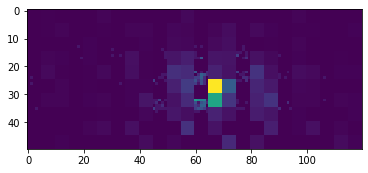

In [96]:
plt.imshow(training_data[7,:,:,0], cmap='viridis', interpolation='None')